*  habanaAI : https://github.com/HabanaAI/Model-References
*  vgg ssd : https://github.com/calmisential/TensorFlow2.0_SSD

In [5]:
import tensorflow as tf
import time

from model.tensorflow.ssd.configuration import IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS, EPOCHS, NUM_CLASSES, BATCH_SIZE, save_model_dir, \
    load_weights_from_epoch, save_frequency, test_images_during_training, \
    test_images_dir_list
from model.tensorflow.ssd.core.ground_truth import ReadDataset
from model.tensorflow.ssd.core.loss import MultiBoxLoss
from model.tensorflow.ssd.core.make_dataset import TFDataset
from model.tensorflow.ssd.core.ssd import SSD

from model.tensorflow.ssd.utils.visualize import visualize_training_results

from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

In [6]:
dataset = TFDataset("dataset/server_room_aug/train_digit_zoom_left_clock.txt")
train_data, train_count = dataset.generate_datatset()

7
182.0 263.0
182.0 182.0
66 66
8
174.0 263.0
174.0 174.0
72 72
8
174.0 263.0
174.0 174.0
58 58
7
182.0 263.0
182.0 182.0
124 124
8
174.0 263.0
174.0 174.0
79 79


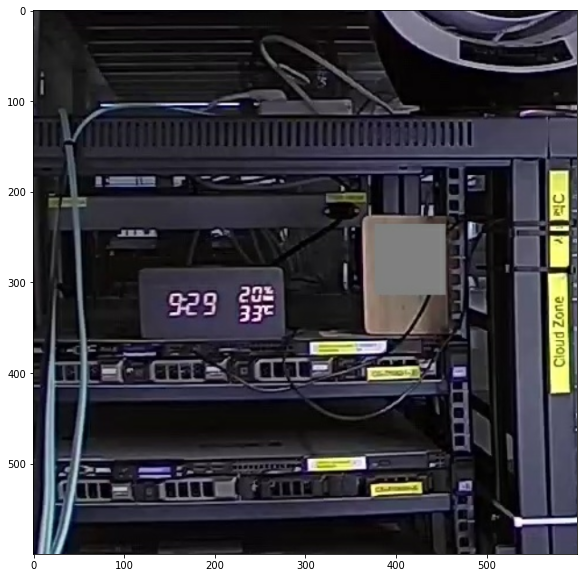

In [26]:
import cv2

for epoch in range(load_weights_from_epoch + 1, EPOCHS):
    start_time = time.time()
    for step, batch_data in enumerate(train_data):
        images, labels = ReadDataset().read(batch_data)
        break
    break

img = images 
from matplotlib import pyplot as plt
plt.imshow(img[0])
plt.show()

cv2.



cv2.rectangle(img=img[0], pt1=(100,100), pt2=(200, 200), color=(255, 0, 0),
                      thickness=1)


In [ ]:


cv2labels[0]

<tf.Tensor: shape=(20, 5), dtype=float32, numpy=
array([[ 0.42      ,  0.50166667,  0.43833333,  0.5316667 , 10.        ],
       [ 0.29      ,  0.51166666,  0.30333334,  0.55333334,  1.        ],
       [ 0.36333334,  0.51166666,  0.37666667,  0.55333334,  1.        ],
       [ 0.32833335,  0.51166666,  0.35      ,  0.55333334,  2.        ],
       [ 0.4       ,  0.50166667,  0.42166665,  0.5316667 ,  2.        ],
       [ 0.40166667,  0.53      ,  0.42166665,  0.56166667,  3.        ],
       [ 0.42166665,  0.5316667 ,  0.44      ,  0.56      ,  5.        ],
       [ 0.30333334,  0.51166666,  0.32333332,  0.55333334,  7.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        , -1.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        , -1.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        , -1.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        , -1.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        , -1.

In [21]:
def print_model_summary(network):
    sample_inputs = tf.random.normal(shape=(1, IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS))
    _ = network(sample_inputs, training=True)
    network.summary()

In [4]:
model = SSD()
print_model_summary(model)

Model: "ssd"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg (VGG)                   multiple                  20500800  
                                                                 
 l2_normalize (L2Normalize)  multiple                  512       
                                                                 
 extra_layer (ExtraLayer)    multiple                  2459520   
                                                                 
 conv2d_23 (Conv2D)          multiple                  73744     
                                                                 
 conv2d_25 (Conv2D)          multiple                  221208    
                                                                 
 conv2d_27 (Conv2D)          multiple                  110616    
                                                                 
 conv2d_29 (Conv2D)          multiple                  55320   

In [5]:
loss_fn = MultiBoxLoss(num_classes=NUM_CLASSES, overlap_thresh=0.5, neg_pos=3)
# optimizer
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-3,
                                                                decay_steps=20000,
                                                                decay_rate=0.96)
optimizer = tf.optimizers.Adam(learning_rate=lr_schedule)

In [6]:
loss_metric = tf.metrics.Mean()
cls_loss_metric = tf.metrics.Mean()
reg_loss_metric = tf.metrics.Mean()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


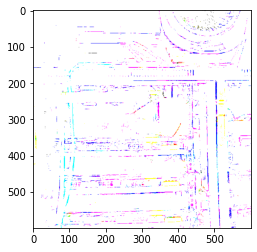

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


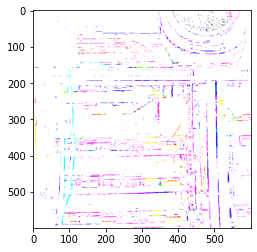

In [4]:
img = images * 255
from matplotlib import pyplot as plt
plt.imshow(img[0])
plt.show()


In [7]:
for epoch in range(load_weights_from_epoch + 1, EPOCHS):
    start_time = time.time()
    for step, batch_data in enumerate(train_data):
        images, labels = ReadDataset().read(batch_data)

        with tf.GradientTape() as tape:
            predictions = model(images, training=True)
            loss_l, loss_c = loss_fn(y_true=labels, y_pred=predictions)
            total_loss = loss_l + loss_c
            
        gradients = tape.gradient(total_loss, model.trainable_variables)
        optimizer.apply_gradients(grads_and_vars=zip(gradients, model.trainable_variables))
        loss_metric.update_state(values=total_loss)
        cls_loss_metric.update_state(values=loss_c)
        reg_loss_metric.update_state(values=loss_l)

        time_per_step = (time.time() - start_time) / (step + 1)
        print("Epoch: {}/{}, step: {}/{}, speed: {:.2f}s/step, loss: {:.10f}, "
                "cls loss: {:.10f}, reg loss: {:.10f}".format(epoch,
                                                            EPOCHS,
                                                            step,
                                                            tf.math.ceil(train_count / BATCH_SIZE),
                                                            time_per_step,
                                                            loss_metric.result(),
                                                            cls_loss_metric.result(),
                                                            reg_loss_metric.result()))
    loss_metric.reset_states()
    cls_loss_metric.reset_states()
    reg_loss_metric.reset_states()

    if epoch % save_frequency == 0:
        model.save_weights(filepath=save_model_dir + "epoch-{}".format(epoch), save_format="tf")

    if test_images_during_training:
        visualize_training_results(pictures=test_images_dir_list, model=model, epoch=epoch)

model.save_weights(filepath=save_model_dir + "epoch-{}".format(EPOCHS), save_format="tf")

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 36)

In [26]:
data = tf.constant(['./dataset/server_room_aug/train_zoom_left_clock/0703_image_4_0_0.jpg 197,307,210,332,0 252,301,263,319,0 211,307,226,332,2 240,301,253,319,2 241,318,253,337,3 253,319,264,335,4 182,307,194,332,7'])

In [28]:
images, labels = ReadDataset().read(data)
predictions = model(images, training=True)

In [33]:
predictions[1][0][0]

<tf.Tensor: shape=(11,), dtype=float32, numpy=
array([-5.350711  , -2.3112283 , -1.0788568 ,  2.290989  ,  1.612336  ,
        0.83810675, -7.500942  , -7.1303267 , -5.455855  , -1.6184428 ,
        2.1470187 ], dtype=float32)>

In [1]:
import os
import cv2

from model.tensorflow.ssd.utils.visualize import visualize_training_results
from model.tensorflow.ssd.test import test_single_picture
from model.tensorflow.ssd.core.ssd import SSD

from matplotlib import pyplot as plt

model = SSD()
checkpoint_path = "./checkpoints/ssd/ssdepoch-49"
model.load_weights(filepath=checkpoint_path)

picture_dir = '/Users/handh/dev/workspace/python/didimdol_ai_model/dataset/server_room_aug/train_zoom_left_clock/1046_image_4_0_0.jpg'
image = test_single_picture(picture_dir=picture_dir, model=model)

#cv2.namedWindow("detect result", flags=cv2.WINDOW_NORMAL)
#cv2.imshow("detect result", image)

plt.imshow(image)	# 이미지 보여주기(matplotlib)
plt.show()

2022-09-05 16:35:41.875480: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


InvalidArgumentError: Incompatible shapes: [34330,2] vs. [8732,2] [Op:Mul]

In [ ]:
model = SSD()
checkpoint_path = "./checkpoints/ssd/ssdepoch-49"
model.load_weights(filepath=checkpoint_path)

2022-09-05 09:48:35.239687: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
picture_dir = '/Users/handh/dev/workspace/python/didimdol_ai_model/dataset/server_room_aug/train_zoom_left_clock/1046_image_4_0_0.jpg'
image = test_single_picture(picture_dir=picture_dir, model=model)
plt.imshow(image)	# 이미지 보여주기(matplotlib)
plt.show()

In [3]:
import tensorflow as tf

In [21]:
t1 = tf.constant([[1,2,3,45],[1,2,3,45],[1,2,3,45]])

In [22]:
t2 = tf.constant([[1,2,3,45],[1,2,3,45],[1,2,3,45]])

In [25]:
tf.concat(values=[t1,t2], axis=0)

<tf.Tensor: shape=(6, 4), dtype=int32, numpy=
array([[ 1,  2,  3, 45],
       [ 1,  2,  3, 45],
       [ 1,  2,  3, 45],
       [ 1,  2,  3, 45],
       [ 1,  2,  3, 45],
       [ 1,  2,  3, 45]], dtype=int32)>

In [24]:
t1.shape, t2.shape

(TensorShape([3, 4]), TensorShape([3, 4]))

In [26]:
a = [1,2,3,4,5,6,7,8,9,0]

In [31]:
a[1:-1]

[2, 3, 4, 5, 6, 7, 8, 9]